# **Ejercicio "Diagnóstico de cáncer de mama"**

*   Base de datos: Breast Cancer Wisconsin Dataset
*   Objetivo: Clasificar tumores como benignos o malignos.

Presentado por:
*   Kaleft Salazar Sánchez
*   Esteban Serna Erazo
*   Juan Eraso Muñoz
*   Cristian Palta Guzmán
*   Santiago Moreno Arcos


In [ ]:
# Importamos las librerías necesarias

import pandas as pd  # Manipulación y análisis de datos en estructuras tipo DataFrame.
import numpy as np  # Operaciones matemáticas y manejo de arreglos multidimensionales.
import matplotlib.pyplot as plt  # Generación de gráficos y visualizaciones.
import seaborn as sns  # Biblioteca basada en Matplotlib para visualizaciones más atractivas.
from sklearn.model_selection import train_test_split  # División del conjunto de datos en entrenamiento y prueba.
from sklearn.preprocessing import StandardScaler  # Normalización de datos para mejorar el rendimiento de los modelos.
from sklearn.svm import SVC  # Implementación de Máquinas de Vectores de Soporte (SVM) para clasificación.
from sklearn.decomposition import PCA  # Reducción de dimensionalidad mediante Análisis de Componentes Principales (PCA).
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix  # Evaluación del modelo mediante métricas de clasificación.
from sklearn.metrics import recall_score  # Cálculo de la métrica de recall (sensibilidad) en clasificación.
from sklearn.model_selection import GridSearchCV  # Búsqueda de hiperparámetros óptimos mediante validación cruzada.


# ✅ **Requerimiento 1:**
**Normalizar los datos y revisar la distribución de clases.**

In [ ]:
# Cargar el dataset
data = pd.read_csv('data.csv')
data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})
data = data.drop(columns=['id', 'Unnamed: 32'])  # Eliminamos la columna 'Unnamed: 32' Por valores nulos

# Mostrar las primeras filas para explorar los datos
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Normalizar los datos
X = data.drop(columns=['diagnosis'])  # Eliminamos 'id' y la variable objetivo 'diagnosis'
y = data['diagnosis']

scaler = StandardScaler() # Escalado de los datos
X_scaled = scaler.fit_transform(X)


In [ ]:
# Visualizar la distribución de las clases
print("Distribución de clases:")
y.value_counts()

Distribución de clases:


,count
diagnosis,
0,357
1,212


In [ ]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ✅ **Requerimiento 2:**
**Aplicar SVM con diferentes kernels y ajustar hiperparámetros.**


In [197]:
# Definir hiperparámetros a evaluar
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],  # Solo afecta a RBF y Sigmoid
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],  # Solo para polinomial
    'coef0': [0, 1, 2]  # Solo para polinomial y sigmoide
}

# Crear y ejecutar GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Convertir resultados en DataFrame para analizar
results_df = pd.DataFrame(grid_search.cv_results_)

In [198]:
# Ver los mejores hiperparámetros para cada kernel
best_params_per_kernel = {}
for kernel in param_grid['kernel']:
    best_for_kernel = results_df[results_df['param_kernel'] == kernel].sort_values('mean_test_score', ascending=False).iloc[0]
    best_params_per_kernel[kernel] = {
        'C': best_for_kernel['param_C'],
        'gamma': best_for_kernel['param_gamma'],
        'degree': best_for_kernel['param_degree'],
        'coef0': best_for_kernel['param_coef0'],
        'accuracy': best_for_kernel['mean_test_score']
    }

In [199]:
# Mostrar los mejores hiperparámetros por kernel y su recall
for kernel, params in best_params_per_kernel.items():
    # Entrenar modelo con los mejores hiperparámetros de cada kernel
    model = SVC(kernel=kernel, C=params['C'], gamma=params['gamma'],
                degree=params['degree'], coef0=params['coef0'])
    model.fit(X_train, y_train)  # Entrenar modelo
    y_pred = model.predict(X_test)  # Hacer predicciones

    # Calcular Recall
    recall = recall_score(y_test, y_pred)

    # Imprimir resultados
    print(f"\n🔹 Mejor configuración para kernel '{kernel}':")
    print(f"   - C: {params['C']}")
    print(f"   - Gamma: {params['gamma']}")
    print(f"   - Degree: {params['degree']}")
    print(f"   - Coef0: {params['coef0']}")
    print(f"   - Precisión (Accuracy): {params['accuracy']:.4f}")
    print(f"   - Recall: {recall:.4f}")  # Se agrega Recall


🔹 Mejor configuración para kernel 'linear':
   - C: 1.0
   - Gamma: 0.01
   - Degree: 2
   - Coef0: 2
   - Precisión (Accuracy): 0.9748
   - Recall: 0.9683

🔹 Mejor configuración para kernel 'rbf':
   - C: 10.0
   - Gamma: 0.01
   - Degree: 3
   - Coef0: 1
   - Precisión (Accuracy): 0.9673
   - Recall: 0.9683

🔹 Mejor configuración para kernel 'poly':
   - C: 0.1
   - Gamma: 0.1
   - Degree: 3
   - Coef0: 2
   - Precisión (Accuracy): 0.9773
   - Recall: 0.9683

🔹 Mejor configuración para kernel 'sigmoid':
   - C: 10.0
   - Gamma: 0.01
   - Degree: 3
   - Coef0: 0
   - Precisión (Accuracy): 0.9698
   - Recall: 0.9841


# ✅ **Requerimiento 3:**
**Usar métodos de reducción de dimensionalidad (PCA).**


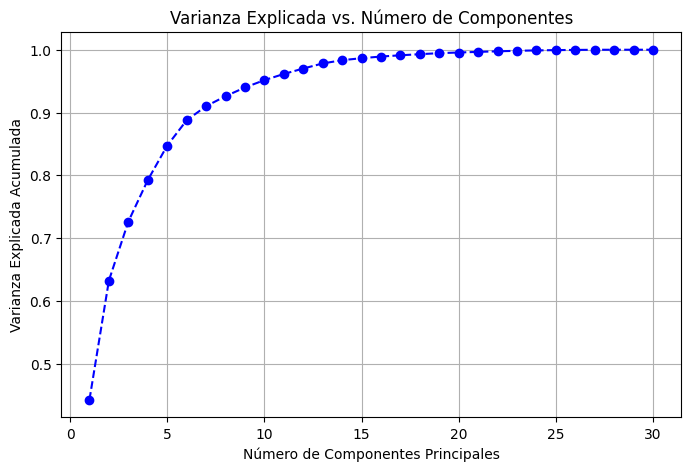

In [200]:
# Aplicar PCA sin reducir el número de componentes para analizar la varianza
pca_full = PCA(n_components=None)
X_pca_full = pca_full.fit_transform(X_scaled)

# Obtener la varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada vs. Número de Componentes')
plt.grid()
plt.show()


In [201]:
# Aplicar PCA con 15 componentes
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Importante: Solo transformamos, no volvemos a hacer fit()

# Crear y ejecutar GridSearchCV con los datos reducidos por PCA
grid_search_pca = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train)

# Convertir resultados en DataFrame para analizar
results_df_pca = pd.DataFrame(grid_search_pca.cv_results_)

In [202]:
# Ver los mejores hiperparámetros para cada kernel después de PCA
best_params_per_kernel_pca = {}
for kernel in param_grid['kernel']:
    best_for_kernel = results_df_pca[results_df_pca['param_kernel'] == kernel].sort_values('mean_test_score', ascending=False).iloc[0]
    best_params_per_kernel_pca[kernel] = {
        'C': best_for_kernel['param_C'],
        'gamma': best_for_kernel['param_gamma'],
        'degree': best_for_kernel['param_degree'],
        'coef0': best_for_kernel['param_coef0'],
        'accuracy': best_for_kernel['mean_test_score']
    }

# Evaluar cada kernel con sus mejores hiperparámetros en PCA
for kernel, params in best_params_per_kernel_pca.items():
    # Entrenar modelo con los mejores hiperparámetros en datos con PCA
    model = SVC(kernel=kernel, C=params['C'], gamma=params['gamma'],
                degree=params['degree'], coef0=params['coef0'])
    model.fit(X_train_pca, y_train)
    y_pred_pca = model.predict(X_test_pca)

    # Calcular Recall con PCA
    recall_pca = recall_score(y_test, y_pred_pca)

    # Imprimir resultados
    print(f"\n🔹 Mejor configuración para kernel '{kernel}' con PCA:")
    print(f"   - C: {params['C']}")
    print(f"   - Gamma: {params['gamma']}")
    print(f"   - Degree: {params['degree']}")
    print(f"   - Coef0: {params['coef0']}")
    print(f"   - Precisión (Accuracy) con PCA: {params['accuracy']:.4f}")
    print(f"   - Recall con PCA: {recall_pca:.4f}")


🔹 Mejor configuración para kernel 'linear' con PCA:
   - C: 0.1
   - Gamma: 0.01
   - Degree: 2
   - Coef0: 0
   - Precisión (Accuracy) con PCA: 0.9774
   - Recall con PCA: 0.9841

🔹 Mejor configuración para kernel 'rbf' con PCA:
   - C: 10.0
   - Gamma: 0.01
   - Degree: 3
   - Coef0: 1
   - Precisión (Accuracy) con PCA: 0.9723
   - Recall con PCA: 0.9683

🔹 Mejor configuración para kernel 'poly' con PCA:
   - C: 0.1
   - Gamma: 0.1
   - Degree: 3
   - Coef0: 2
   - Precisión (Accuracy) con PCA: 0.9773
   - Recall con PCA: 0.9683

🔹 Mejor configuración para kernel 'sigmoid' con PCA:
   - C: 10.0
   - Gamma: 0.01
   - Degree: 3
   - Coef0: 0
   - Precisión (Accuracy) con PCA: 0.9724
   - Recall con PCA: 0.9841


# ✅ **Requerimiento 4:**
**Evaluar con matriz de confusión, recall y precisión.**


Funcion para crear las matriz de confusion, basado en el mejor kernel y la integracion de PCA

In [203]:
def mostrar_matriz_confusion(kernel_name, usar_pca=False):

    # Seleccionar el conjunto de datos según si se usa PCA o no
    X_train_selected = X_train_pca if usar_pca else X_train
    X_test_selected = X_test_pca if usar_pca else X_test

    # Obtener los mejores hiperparámetros dependiendo del uso de PCA
    best_params = best_params_per_kernel_pca[kernel_name] if usar_pca else best_params_per_kernel[kernel_name]

    # Crear y entrenar el modelo SVM con los mejores hiperparámetros
    model = SVC(kernel=kernel_name, C=best_params['C'], degree=best_params['degree'], coef0=best_params['coef0'])
    model.fit(X_train_selected, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test_selected)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Mostrar la matriz de confusión gráficamente
    tipo_modelo = "con PCA" if usar_pca else "sin PCA"
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benigno (0)", "Maligno (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - Kernel {kernel_name.capitalize()} ({tipo_modelo})")
    plt.show()

Llamado de la funcion para la matriz de confusion con el mejor modelo sin PCA


🔹 Modelo SIN PCA:


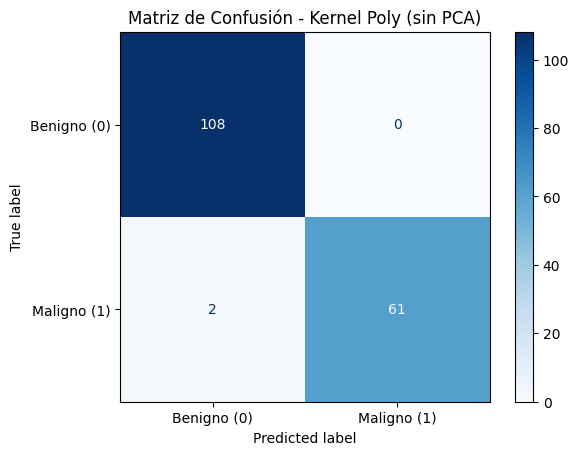

In [204]:
print("\n🔹 Modelo SIN PCA:")
mostrar_matriz_confusion("poly", usar_pca=False)  # Sin PCA

Llamado de la funcion para la matriz de confusion con el mejor modelo con PCA


🔹 Modelo CON PCA:


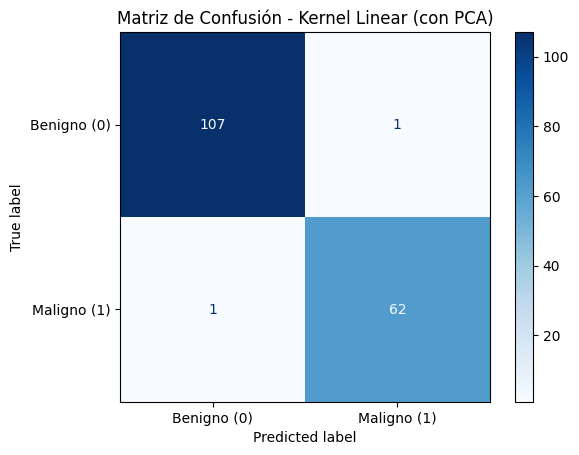

In [205]:
print("\n🔹 Modelo CON PCA:")
mostrar_matriz_confusion("linear", usar_pca=True)   # Con PCA